## Unsupervised DL project - BYOL - Temirlan Turysbek
please use table of contents on the left for a better understanding.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install byol-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import time
import copy
from os import listdir
from os.path import isfile, join
from skimage import io
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from byol_pytorch import BYOL
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from torchvision.io import read_image
from PIL import Image
from sklearn.model_selection import train_test_split

put your files from DRAC challenge to your google drive at the following folders:

In [ ]:
PATH_PROJECT = '/content/drive/MyDrive/BYOL/'
PATH_PROJECT_C = '/content/drive/MyDrive/BYOL/C. Diabetic Retinopathy Grading/'

TARGET_SIZE = (512, 512)

BATCH_SIZE = 8

TEST_SIZE = 0.2

SEED = 42

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# BYOL training:
Here I use implementation of BYOL and train the learner on retina images from DRAC challenge


In [ ]:
# Custom dataloader for retina images
class UnlabelledRetinaDataset(Dataset):
    """ Unlabelled Retina images dataset """

    def __init__(self, path):
        self.files_names = [f for f in listdir(path) if isfile(join(path, f))]
        self.root_dir = path

    def __len__(self):
        return len(self.files_names)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = join(self.root_dir, self.files_names[idx])
        image = Image.open(img_path).convert('RGB')
        image = transforms.Resize(TARGET_SIZE)(image)
        image = transforms.ToTensor()(image)
        return image

In [ ]:
urd = UnlabelledRetinaDataset(join(PATH_PROJECT, 'all_samples'))

In [ ]:
unlabelled_data_loader = DataLoader(urd, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


Training pipeline:

In [ ]:
# architecture definition
resnet = models.resnet50(weights=None)

In [ ]:
learner = BYOL(
    resnet,
    image_size = TARGET_SIZE[0],
    hidden_layer = 'avgpool'
)

In [ ]:
learner = learner.to(device)

In [ ]:
optimizer = optim.SGD(learner.parameters(), lr=0.001, momentum=0.9)
# opt = torch.optim.Adam(learner.parameters(), lr=3e-4)

BYOL_EPOCHS = 40

for epoch in range(BYOL_EPOCHS):
    print('Epoch {}/{}'.format(epoch+1, BYOL_EPOCHS))
    print('-' * 10)

    running_loss = 0.0
    for i, data in enumerate(unlabelled_data_loader):
        
        images = data.to(device)
        loss = learner(images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        learner.update_moving_average() # update moving average of target encoder
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(urd)
    print(f'Epoch loss: {epoch_loss:.4f}\n')

torch.save(resnet.state_dict(), join(PATH_PROJECT, './byol_encoder_net.pt'))

Epoch 1/40
----------
Epoch loss: 1.5258

Epoch 2/40
----------
Epoch loss: 1.0706

Epoch 3/40
----------
Epoch loss: 1.0293

Epoch 4/40
----------
Epoch loss: 1.0595

Epoch 5/40
----------
Epoch loss: 0.9547

Epoch 6/40
----------
Epoch loss: 0.8931

Epoch 7/40
----------
Epoch loss: 0.5479

Epoch 8/40
----------
Epoch loss: 0.8346

Epoch 9/40
----------
Epoch loss: 0.6378

Epoch 10/40
----------
Epoch loss: 0.7086

Epoch 11/40
----------
Epoch loss: 0.8085

Epoch 12/40
----------
Epoch loss: 0.7100

Epoch 13/40
----------
Epoch loss: 0.7348

Epoch 14/40
----------
Epoch loss: 0.6929

Epoch 15/40
----------
Epoch loss: 0.6666

Epoch 16/40
----------
Epoch loss: 0.7598

Epoch 17/40
----------
Epoch loss: 0.7947

Epoch 18/40
----------
Epoch loss: 0.7840

Epoch 19/40
----------
Epoch loss: 0.6459

Epoch 20/40
----------
Epoch loss: 0.6955

Epoch 21/40
----------
Epoch loss: 0.5769

Epoch 22/40
----------
Epoch loss: 0.6283

Epoch 23/40
----------
Epoch loss: 0.4831

Epoch 24/40
--------

now we are done with training BYOL and finding initial weights for our resnet. We can observe that the loss is going down. Let's see how it performs in the next chapter.

# task C. DR Grading
now we compare BYOL-initialised weights with Image-Net-initialised weights in the context of Task C of DRAC challenge.

## Prepare data loaders:
now we need to prepare data loaders

In [ ]:
# Custom dataloader for Task C
class TaskCDataset(Dataset):
    """ Retina images dataset for task C """

    def __init__(self, imgs_path, lbls_path):
        self.imgs_path = imgs_path
        self.dataset = pd.read_csv(lbls_path)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        filename = self.dataset.iloc[idx, 0]
        label = self.dataset.iloc[idx, 1]
        img_path = join(self.imgs_path, filename)
        image = Image.open(img_path).convert('RGB').resize(TARGET_SIZE)
        image = transforms.ToTensor()(image)
        
        sample = {'image':image, 'label':label}
        return sample

In [ ]:
c_dataset = TaskCDataset(
    imgs_path=join(PATH_PROJECT, 'C. Diabetic Retinopathy Grading/1. Original Images/a. Training Set'),
    lbls_path=join(PATH_PROJECT, 'C. Diabetic Retinopathy Grading/2. Groundtruths/a. DRAC2022_ Diabetic Retinopathy Grading_Training Labels.csv')
)

split train set and val set in stratified manner because there very few samples and the dataset is imbalanced.

In [ ]:
# stratify train_test_split of indices
train_indices, val_indices, _, _ = train_test_split(
    range(len(c_dataset)),
    c_dataset.dataset['DR grade'],
    stratify=c_dataset.dataset['DR grade'],
    test_size=TEST_SIZE,
    random_state=SEED
)

c_image_datasets = {
    'train': Subset(c_dataset, train_indices),
    'val': Subset(c_dataset, val_indices)
}

c_dataloaders = {
    'train': DataLoader(c_image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(c_image_datasets['val'], batch_size=BATCH_SIZE, shuffle=True)
}

## Define training pipeline:
training pipeline trains the model and saves the best performed model's weights so that they can be used later.

In [ ]:
def train_model(model, criterion, optimizer, experiment_name, num_epochs=3):

    best_acc = 0.0
    best_epoch = 0
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    for epoch in range(num_epochs):
        start_time = time.time()

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for batch in c_dataloaders[phase]:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(c_image_datasets[phase])
            epoch_acc = running_corrects.double() / len(c_image_datasets[phase])
            history[phase + '_loss'].append(epoch_loss)
            history[phase + '_acc'].append(epoch_acc.item())
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                torch.save(model.state_dict(), join(PATH_PROJECT_C, experiment_name + '_best.pt'))

        time_elapsed = time.time() - start_time
        print(f'Epoch time {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s\n')

    print(f'Best val Acc: {best_acc:4f} at epoch: {best_epoch}')
    model.load_state_dict(torch.load(join(PATH_PROJECT_C, experiment_name + '_best.pt')))
    return model, history

function to plot the graph of accuracy and loss:

In [ ]:
def plot_metrics(history):
    print(history.keys())
    # summarize history for accuracy
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


## Resnet (BYOL-pretrained)
here I test resnet50 (with BYOL-initialised weights) with transfer learning. I froze resnet layers and added simple MLP to the end that can learn.

In [ ]:
model = models.resnet50(weights=None)
model.load_state_dict(torch.load(join(PATH_PROJECT, './byol_encoder_net.pt')))

<All keys matched successfully>

In [ ]:
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
        nn.Linear(2048, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 3))

model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters())
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


In [ ]:
model_trained, history = train_model(model, criterion, optimizer, 'resnet50_byol_pretrained', num_epochs=30)


Epoch 1/30
----------
train loss: 1.0044, acc: 0.5184
val loss: 0.9722, acc: 0.5366
Epoch time 0m 22s

Epoch 2/30
----------
train loss: 0.9584, acc: 0.5410
val loss: 0.9560, acc: 0.5366
Epoch time 0m 22s

Epoch 3/30
----------
train loss: 0.9655, acc: 0.5307
val loss: 0.9931, acc: 0.5366
Epoch time 0m 22s

Epoch 4/30
----------
train loss: 0.9576, acc: 0.5369
val loss: 0.9584, acc: 0.5366
Epoch time 0m 22s

Epoch 5/30
----------
train loss: 0.9557, acc: 0.5369
val loss: 0.9479, acc: 0.5366
Epoch time 0m 22s

Epoch 6/30
----------
train loss: 0.9506, acc: 0.5369
val loss: 0.9508, acc: 0.5366
Epoch time 0m 22s

Epoch 7/30
----------
train loss: 0.9439, acc: 0.5266
val loss: 0.9465, acc: 0.5366
Epoch time 0m 22s

Epoch 8/30
----------
train loss: 0.9641, acc: 0.5020
val loss: 0.9471, acc: 0.5366
Epoch time 0m 22s

Epoch 9/30
----------
train loss: 0.9602, acc: 0.5287
val loss: 0.9443, acc: 0.5366
Epoch time 0m 22s

Epoch 10/30
----------
train loss: 0.9493, acc: 0.5369
val loss: 0.9382, 

dict_keys(['train_acc', 'val_acc', 'train_loss', 'val_loss'])


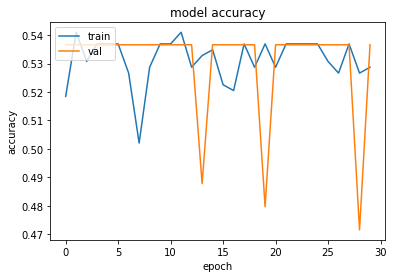

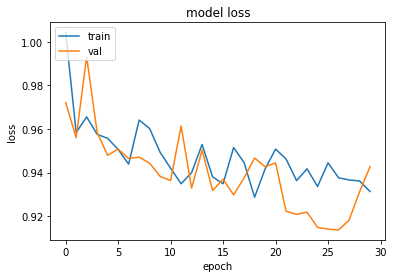

In [ ]:
plot_metrics(history)

we see that despite the fact that the loss is going down, the model accuracy is "stuck" at value 0.5366. Reason might be imbalanced/too small dataset, and model learning nothing.

## Resnet50 trained from scratch
here we test resnet50 randomly initialised:

In [ ]:
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

model_trained, history = train_model(model, criterion, optimizer, 'resnet50_from_scratch', num_epochs=30)


Epoch 1/30
----------
train loss: 1.8839, acc: 0.4242
val loss: 0.9573, acc: 0.5366
Epoch time 6m 0s

Epoch 2/30
----------
train loss: 1.4867, acc: 0.4221
val loss: 2.0377, acc: 0.3496
Epoch time 0m 30s

Epoch 3/30
----------
train loss: 1.4373, acc: 0.4508
val loss: 1.0083, acc: 0.3821
Epoch time 0m 30s

Epoch 4/30
----------
train loss: 1.4390, acc: 0.4344
val loss: 1.6410, acc: 0.5366
Epoch time 0m 30s

Epoch 5/30
----------
train loss: 1.3747, acc: 0.4549
val loss: 2.0075, acc: 0.2439
Epoch time 0m 30s

Epoch 6/30
----------
train loss: 1.6890, acc: 0.4467
val loss: 2.0981, acc: 0.3089
Epoch time 0m 30s

Epoch 7/30
----------
train loss: 1.4596, acc: 0.4816
val loss: 0.9420, acc: 0.5366
Epoch time 0m 30s

Epoch 8/30
----------
train loss: 1.4083, acc: 0.4426
val loss: 1.2269, acc: 0.2764
Epoch time 0m 30s

Epoch 9/30
----------
train loss: 1.9963, acc: 0.4467
val loss: 1.0382, acc: 0.5366
Epoch time 0m 30s

Epoch 10/30
----------
train loss: 1.2561, acc: 0.4611
val loss: 1.0841, a

dict_keys(['train_acc', 'val_acc', 'train_loss', 'val_loss'])


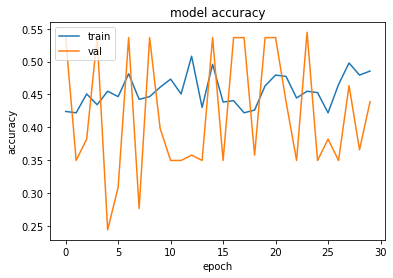

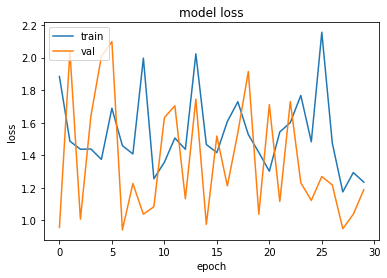

In [ ]:
plot_metrics(history)

the results are not very promising.

## Resnet50 (ImageNet-pretrained)
and now let's try ImageNet-pretrained resnet50

In [ ]:
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

model_trained, history = train_model(model, criterion, optimizer, 'resnet50_imagenet_pretrained', num_epochs=30)


Epoch 1/30
----------
train loss: 0.9610, acc: 0.5123
val loss: 0.9412, acc: 0.5447
Epoch time 0m 31s

Epoch 2/30
----------
train loss: 0.8788, acc: 0.5799
val loss: 0.8576, acc: 0.5691
Epoch time 0m 31s

Epoch 3/30
----------
train loss: 0.8294, acc: 0.6025
val loss: 0.8340, acc: 0.6341
Epoch time 0m 31s

Epoch 4/30
----------
train loss: 0.8097, acc: 0.6803
val loss: 0.7994, acc: 0.6423
Epoch time 0m 31s

Epoch 5/30
----------
train loss: 0.7777, acc: 0.6660
val loss: 0.7780, acc: 0.6179
Epoch time 0m 30s

Epoch 6/30
----------
train loss: 0.7513, acc: 0.6803
val loss: 0.7829, acc: 0.5854
Epoch time 0m 30s

Epoch 7/30
----------
train loss: 0.7259, acc: 0.6906
val loss: 0.7440, acc: 0.6504
Epoch time 0m 31s

Epoch 8/30
----------
train loss: 0.7195, acc: 0.6906
val loss: 0.7320, acc: 0.6423
Epoch time 0m 30s

Epoch 9/30
----------
train loss: 0.7142, acc: 0.6967
val loss: 0.7137, acc: 0.6829
Epoch time 0m 31s

Epoch 10/30
----------
train loss: 0.6887, acc: 0.7336
val loss: 0.7190, 

dict_keys(['train_acc', 'val_acc', 'train_loss', 'val_loss'])


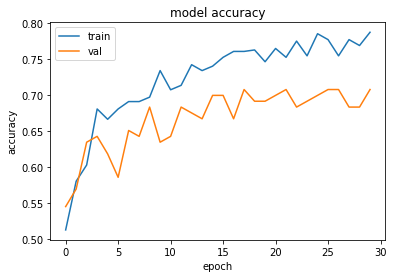

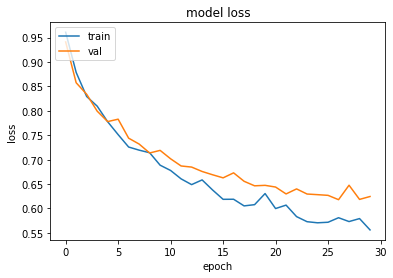

In [ ]:
plot_metrics(history)

we see that it follows nice pattern of accuracy and loss. Since it's the most promising model at later chapters we are going to imrpove and make it more advanced.

## Evaluation on Test set
the following code creates dataloaders for test set and runs the data through the best performed model saved earlier.

In [ ]:
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model.load_state_dict(torch.load(join(PATH_PROJECT_C, './resnet50_imagenet_pretrained_best.pt')))

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
PATH_TEST_C = join(PATH_PROJECT_C, '1. Original Images/b. Testing Set')

In [ ]:
test_dataset_c = UnlabelledRetinaDataset(PATH_TEST_C)

In [ ]:
test_dataloader_c = DataLoader(test_dataset_c, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
probs = []
for i, data in enumerate(test_dataloader_c):
    imgs = data.to(device)
    pred_logits_tensor = model(imgs)
    pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
    probs.append(pred_probs)

In [ ]:
probs = np.vstack(probs)

In [ ]:
results_np = np.hstack([
    np.array(test_dataset_c.files_names).reshape((-1, 1)),
    np.argmax(probs, 1).reshape((-1, 1)),
    probs])

In [ ]:
results_np[:10]

array([['1134.png', '1', '0.28298295', '0.51183236', '0.20518468'],
       ['954.png', '1', '0.24911624', '0.6285939', '0.12228983'],
       ['916.png', '0', '0.7803023', '0.18646273', '0.03323493'],
       ['917.png', '0', '0.61922663', '0.28904942', '0.091723956'],
       ['932.png', '1', '0.1789237', '0.61405283', '0.20702344'],
       ['915.png', '0', '0.8228008', '0.15418583', '0.023013437'],
       ['1269.png', '0', '0.6865113', '0.27028275', '0.043205988'],
       ['1268.png', '0', '0.6086015', '0.3579533', '0.03344518'],
       ['903.png', '0', '0.6577769', '0.29006293', '0.052160136'],
       ['1253.png', '1', '0.28879565', '0.59239316', '0.118811145']],
      dtype='<U32')

In [ ]:
results = pd.DataFrame(data=results_np, columns=['case', 'class', 'P0', 'P1', 'P2'])
results.head()

,case,class,P0,P1,P2
0,1134.png,1,0.28298295,0.51183236,0.20518468
1,954.png,1,0.24911624,0.6285939,0.12228983
2,916.png,0,0.7803023,0.18646273,0.03323493
3,917.png,0,0.61922663,0.28904942,0.091723956
4,932.png,1,0.1789237,0.61405283,0.20702344


In [ ]:
results.to_csv(join(PATH_PROJECT_C, 'awzrd.csv'), index=False)

## Improved version: 
in this chapter let's modify our data and model. The following is applied now:


*   Since dataset is limited, I extended it with additional 4 augmentations for each image in train set.
*   Dataset was normalized by the calculated mean and std of dataset.
*   Loss function was calculated with **weight** argument, to accomodate for imbalanced weight distribution
*   Two models with Resnet50 were used: 
    *   frozen 48 layers + flatten() + 3 layer MLP (trainable)
    *   frozen 49 layers + 3 layer MLP (trainable) (Spoiler alert: this is the best option)





### **Extending** the dataset:
since there are very few samples, we are going to extend the dataset by adding flipped and rotated copies of images. In order not to interfere and augment validation set, we are going to first divide dataset into train, and validation set in stratified manner, and then extend only train set and use validation set as it is.

In [ ]:
from skimage.io import imread, imsave
from tqdm import tqdm
from skimage.transform import rotate

In [ ]:
# adjust paths accordingly
image_folder = join(PATH_PROJECT, 'C. Diabetic Retinopathy Grading/1. Original Images/a. Training Set')
label_path = join(PATH_PROJECT, 'C. Diabetic Retinopathy Grading/2. Groundtruths/a. DRAC2022_ Diabetic Retinopathy Grading_Training Labels.csv')

In [ ]:
data = pd.read_csv(label_path)

In [ ]:
data.head()

,image name,DR grade
0,001.png,0
1,002.png,0
2,003.png,0
3,004.png,0
4,005.png,0


In [ ]:
# loading images
train_img = []
for img_name in tqdm(data['image name']):
    image_path = join(image_folder, img_name)
    img = imread(image_path)
    train_img.append(img)

train_x = np.array(train_img)
train_y = data['DR grade'].values
train_x.shape, train_y.shape

100%|██████████| 611/611 [00:07<00:00, 76.88it/s]


((611, 1024, 1024), (611,))

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=train_y
)

(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((488, 1024, 1024), (488,)), ((123, 1024, 1024), (123,)))

let's save validation images into separate folder:

In [ ]:
new_val_path = join(PATH_PROJECT, 'C. Diabetic Retinopathy Grading/1. Original Images/Validation')
original_images_folder = join(PATH_PROJECT, 'C. Diabetic Retinopathy Grading/1. Original Images')

In [ ]:
name_col = []
label_col = []
for i in tqdm(range(val_x.shape[0])):
    filename = str(i) + '.png'
    imsave(join(new_val_path, filename), val_x[i])
    name_col.append(filename)
    label_col.append(val_y[i])
val_df = pd.DataFrame(data={'image name': name_col, 'DR grade': label_col})
val_df.to_csv(join(original_images_folder + 'val_table.csv'), index=False)

100%|██████████| 123/123 [00:11<00:00, 10.58it/s]


In [ ]:
val_df.head()

,image name,DR grade
0,0.png,0
1,1.png,2
2,2.png,1
3,3.png,1
4,4.png,0


now we save extended train set into another folder:

In [ ]:
new_train_path = join(PATH_PROJECT, 'C. Diabetic Retinopathy Grading/1. Original Images/Training_augmented')

for each image we add additional 45 deg.rotated, 135 deg.rotated, flipped from right to left, and flipped upside down.

In [ ]:
name_col = []
label_col = []
for i in tqdm(range(train_x.shape[0])):
    filename = str(i) + '_original.png'
    imsave(join(new_train_path, filename), train_x[i])
    name_col.append(filename)

    filename = str(i) + '_rotate45.png'
    imsave(join(new_train_path, filename), rotate(train_x[i], angle=45, mode = 'wrap'))
    name_col.append(filename)

    filename = str(i) + '_rotate135.png'
    imsave(join(new_train_path, filename), rotate(train_x[i], angle=135, mode = 'wrap'))
    name_col.append(filename)

    filename = str(i) + '_fliplr.png'
    imsave(join(new_train_path, filename), np.fliplr(train_x[i]))
    name_col.append(filename)

    filename = str(i) + '_flipud.png'
    imsave(join(new_train_path, filename), np.flipud(train_x[i]))
    name_col.append(filename)

    for j in range(5):
        label_col.append(train_y[i])

100%|██████████| 488/488 [04:45<00:00,  1.71it/s]


In [ ]:
train_df = pd.DataFrame(data={'image name': name_col, 'DR grade': label_col})
train_df.to_csv(join(original_images_folder + 'train_table.csv'), index=False)

In [ ]:
train_df.head()

,image name,DR grade
0,0_original.png,0
1,0_rotate45.png,0
2,0_rotate135.png,0
3,0_fliplr.png,0
4,0_flipud.png,0


### Prepare new data loaders:
now we need to modify previous data loaders, and compute mean and std of our dataset so that the images are normalized.

In [ ]:
dataset_k = UnlabelledRetinaDataset(join(PATH_PROJECT, 'C. Diabetic Retinopathy Grading/1. Original Images/a. Training Set'))

In [ ]:
dataloader_k = DataLoader(dataset_k, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data in dataloader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [ ]:
mean, std = get_mean_and_std(dataloader_k)

In [ ]:
print(mean, std)

tensor([0.4138, 0.4138, 0.4138]) tensor([0.2269, 0.2269, 0.2269])


now we can prepare data loaders:

In [ ]:
# Custom dataloader for Task C
class TaskCDataset(Dataset):
    """ Retina images dataset for task C """

    def __init__(self, imgs_path, lbls_path):
        self.imgs_path = imgs_path
        self.dataset = pd.read_csv(lbls_path)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        filename = self.dataset.iloc[idx, 0]
        label = self.dataset.iloc[idx, 1]
        img_path = join(self.imgs_path, filename)
        image = Image.open(img_path).convert('RGB')
        image = transforms.Resize(TARGET_SIZE)(image)
        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=mean, std=std)(image)
        
        sample = {'image':image, 'label':label}
        return sample

In [ ]:
c_dataset_train = TaskCDataset(
    imgs_path=join(PATH_PROJECT, 'C. Diabetic Retinopathy Grading/1. Original Images/Training_augmented'),
    lbls_path=join(PATH_PROJECT, 'C. Diabetic Retinopathy Grading/1. Original Imagestrain_table.csv')
)

c_dataset_val = TaskCDataset(
    imgs_path=join(PATH_PROJECT, 'C. Diabetic Retinopathy Grading/1. Original Images/Validation'),
    lbls_path=join(PATH_PROJECT, 'C. Diabetic Retinopathy Grading/1. Original Imagesval_table.csv')
)

In [ ]:
c_image_datasets = {
    'train': c_dataset_train,
    'val': c_dataset_val
}

In [ ]:
c_dataloaders = {
    'train': DataLoader(c_image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(c_image_datasets['val'], batch_size=BATCH_SIZE, shuffle=True)
}

In [ ]:
c_dataset_train.dataset['DR grade'].value_counts()

0    1310
1     850
2     280
Name: DR grade, dtype: int64

In [ ]:
c_dataset_val.dataset['DR grade'].value_counts()

0    66
1    43
2    14
Name: DR grade, dtype: int64

as we wanted from above we see that we extended only train set.

### Now we define our models 
Since we use training pipelines from above, there is no need to modify them.

In [ ]:
weight = 1310 / torch.tensor([1310, 850, 280])
weight = weight.cuda()

In [ ]:
weight

tensor([1.0000, 1.5412, 4.6786], device='cuda:0')

the model with frozen 48 layer of resnet + flattened() + 3 layer trainable MLP

In [ ]:
class CustomResnet48(nn.Module):
    def __init__(self):
        super(CustomResnet48, self).__init__()
        
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        modules = list(resnet.children())[:-2]  # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        self.last_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(524288, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3))
        
    def forward(self, x):
        output_48 = self.resnet(x)
        output = self.last_layers(output_48)
        return output

In [ ]:
custom_model = CustomResnet48().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.SGD(custom_model.last_layers.parameters(), lr=0.001, momentum=0.9)

model_trained, history = train_model(custom_model, criterion, optimizer, 'resnet48_imagenet_pretrained', num_epochs=10)

Epoch 1/10
----------
train loss: 0.2802, acc: 0.9217
val loss: 1.0675, acc: 0.6829
Epoch time 2m 15s

Epoch 2/10
----------
train loss: 0.1025, acc: 0.9758
val loss: 1.3848, acc: 0.6667
Epoch time 1m 44s

Epoch 3/10
----------
train loss: 0.0398, acc: 0.9906
val loss: 2.0382, acc: 0.6748
Epoch time 1m 43s

Epoch 4/10
----------
train loss: 0.0164, acc: 0.9955
val loss: 2.4604, acc: 0.6585
Epoch time 1m 43s

Epoch 5/10
----------
train loss: 0.0083, acc: 0.9959
val loss: 2.3344, acc: 0.6911
Epoch time 1m 47s

Epoch 6/10
----------
train loss: 0.0035, acc: 0.9992
val loss: 2.6193, acc: 0.7073
Epoch time 1m 48s

Epoch 7/10
----------
train loss: 0.0127, acc: 0.9980
val loss: 2.4689, acc: 0.6911
Epoch time 1m 46s

Epoch 8/10
----------
train loss: 0.0086, acc: 0.9980
val loss: 2.5299, acc: 0.6748
Epoch time 1m 43s

Epoch 9/10
----------
train loss: 0.0019, acc: 1.0000
val loss: 2.4587, acc: 0.7154
Epoch time 1m 48s

Epoch 10/10
----------
train loss: 0.0007, acc: 1.0000
val loss: 2.5824, 

dict_keys(['train_acc', 'val_acc', 'train_loss', 'val_loss'])


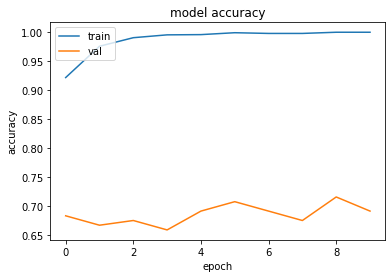

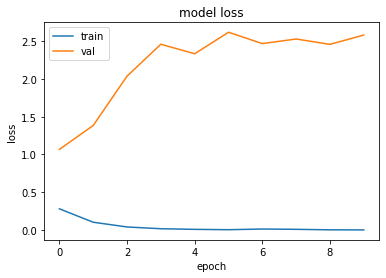

In [ ]:
plot_metrics(history)

we see that the model overfitted even under 10 epochs (model's accuracy on train set is 1)

The 2nd model is Resnet50 (imagenet pretrained) + 3 layer trainable MLP

In [ ]:
class CustomResnet50(nn.Module):
    def __init__(self):
        super(CustomResnet50, self).__init__()
        
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        self.resnet.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3))
        
    def forward(self, x):
        output = self.resnet(x)
        return output

In [ ]:
custom_model = CustomResnet50().to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# verify params are learnable
for name, param in custom_model.named_parameters():
    if param.requires_grad:
        print(name)

resnet.fc.0.weight
resnet.fc.0.bias
resnet.fc.2.weight
resnet.fc.2.bias
resnet.fc.4.weight
resnet.fc.4.bias


In [ ]:
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.SGD(custom_model.resnet.fc.parameters(), lr=0.001, momentum=0.9)

model_trained, history = train_model(custom_model, criterion, optimizer, 'resnet50_imagenet_pretrained', num_epochs=30)

Epoch 1/30
----------
train loss: 1.0810, acc: 0.5246
val loss: 1.0471, acc: 0.5935
Epoch time 31m 34s

Epoch 2/30
----------
train loss: 1.0167, acc: 0.6311
val loss: 0.9232, acc: 0.6504
Epoch time 1m 49s

Epoch 3/30
----------
train loss: 0.8530, acc: 0.6652
val loss: 0.7917, acc: 0.6260
Epoch time 1m 50s

Epoch 4/30
----------
train loss: 0.7474, acc: 0.6713
val loss: 0.7217, acc: 0.6829
Epoch time 1m 51s

Epoch 5/30
----------
train loss: 0.7036, acc: 0.6885
val loss: 0.6956, acc: 0.6911
Epoch time 1m 52s

Epoch 6/30
----------
train loss: 0.6601, acc: 0.7172
val loss: 0.6433, acc: 0.7154
Epoch time 1m 52s

Epoch 7/30
----------
train loss: 0.6291, acc: 0.7311
val loss: 0.7003, acc: 0.6992
Epoch time 1m 52s

Epoch 8/30
----------
train loss: 0.6189, acc: 0.7262
val loss: 0.6837, acc: 0.7154
Epoch time 1m 51s

Epoch 9/30
----------
train loss: 0.5902, acc: 0.7512
val loss: 0.7032, acc: 0.6992
Epoch time 1m 51s

Epoch 10/30
----------
train loss: 0.5902, acc: 0.7430
val loss: 0.6586,

dict_keys(['train_acc', 'val_acc', 'train_loss', 'val_loss'])


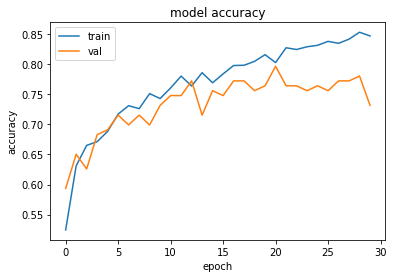

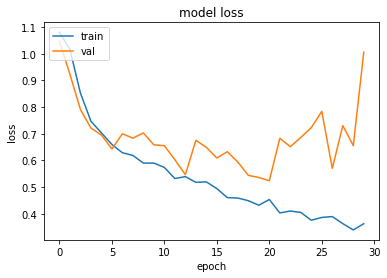

In [ ]:
plot_metrics(history)

we can see that the training follows nice pattern. As can be seen from logs: *Best val Acc: 0.796748 at epoch: 20*
Thus, our new tweaks made our model perform better.